# Tutorial 2 - Inferring Protein Activity from scRNA-seq data from multiple cell populations with the meta-VIPER approach

This tutorial explores the use of metaVIPER to assess protein activity by integrative analysis using multiple gene regulatory networks. metaVIPER is particularly useful in real-world scenarios to infer protein activity in a tissue-independent manner by using multiple, non-tissue-matched interactomes, assuming that transcriptional targets of each protein can be recapitulated by one or more available interactomes. The `viper` function allows running metaVIPER using both [aREA](https://www.nature.com/articles/ng.3593) and [NaRnEA](https://www.mdpi.com/1099-4300/25/3/542) enrichment methods. For additional details, please refer to [Ding et al., 2016](https://www.nature.com/articles/s41467-018-03843-3). After a brief description of the installation procedure and the modules needed, this notebook is organized in the following sections.

**Table of Contents**

[Step 1. Load a gene expression matrix and associated metadata](#1)\
[Step 2. Preprocess and generate a gene expression signature at the single-cell level](#2)\
[Step 3. Load multiple ARACNe-inferred gene regulatory networks](#3)\
[Step 4. Analyze single-cells at the Protein Activity level](#4)\
[Step 5. Pathway enrichment analysis](#5)\
[Key Takeaways](#6)



### Install PyVIPER
Install `pyviper` from PyPI using pip. Alternatively, refer to the README in the current GitHub to install from the local directory.

In [1]:
# !pip install viper-in-python

### Import modules
Load `pyviper` and additional modules required used in this tutorial.

In [2]:
import pyviper
import scanpy as sc
import anndata 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


import warnings
warnings.filterwarnings("ignore", message=".*The 'nopython' keyword.*") # for jit decorator issue with sc.pp.neighbors (09/30/2023)

/Users/lucazanella7/mambaforge/envs/pyviper_development_test/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Setup the path to the data.

In [3]:
data_location = "https://zenodo.org/records/10059791/files/"

We will import the data directly from the above link. Optionally, users are allowed to download the files from [here](https://zenodo.org/records/10059791) and to load them from their local computer. If the second option is preferred, the following lines can be uncommented and run to download the data on Unix systems and set the working directory to the path where the data will be stored. 

In [4]:
#!mkdir Tutorial_2_data_dir 
#%cd Tutorial_2_data_dir
#!curl -O "{data_location}Tutorial_2_counts_mixed_4632.tsv.gz" -O "{data_location}Tutorial_2_metadata_mixed_4632.tsv.gz"
#!curl -O "{data_location}B-cell-net.tsv" -O "{data_location}ductal-2-net.tsv" -O "{data_location}fibroblast-net.tsv" -O "{data_location}stellate-net.tsv"
#data_location = !pwd 
#data_location = data_location[0]+"/" # new value for data if working on data downloaded locally 

### Step 1. Load a gene expression matrix and associated metadata  
<a id='1'></a>
Load the gene expression matrix (UMIs) and store it into an [AnnData](https://anndata.readthedocs.io/en/latest/) object to enable interoperability with [scanpy](https://scanpy-tutorials.readthedocs.io/en/latest/#). Cells used in this tutorial were sampled from scRNA-seq data published in [Peng et al., 2019](https://www.nature.com/articles/s41422-019-0195-y).  

In [5]:
gExpr_path = data_location + "Tutorial_2_counts_mixed_4632.tsv.gz" # path to gene expression matrix (UMI counts)
adata_gExpr = pd.read_csv(gExpr_path, sep="\t") # read from remote 
adata_gExpr = sc.AnnData(adata_gExpr) # convert to AnnData object

Display matrix dimensions (cells x genes)

In [6]:
adata_gExpr

AnnData object with n_obs × n_vars = 4632 × 24005

Load cell-associated metadata. 

In [7]:
metadata_path = data_location + "Tutorial_2_metadata_mixed_4632.tsv.gz" # path to cells metadata
cells_metadata = pd.read_csv(metadata_path, sep="\t")  # load it

Store the metadata in the `adata_gExpr` object as observation annotation.

In [8]:
adata_gExpr.obs = pd.merge(adata_gExpr.obs, cells_metadata, how="left",left_index=True, right_index=True) # store cell-specific metadata as annotation observation

Display the observation annotation from the AnnData object.

In [9]:
adata_gExpr.obs.head()

,Cell_Type
T1_AACCATGCACAACTGT,Ductal cell type 2
T1_AAGACCTAGTCATGCT,Ductal cell type 2
T1_ACATACGAGACTCGGA,Ductal cell type 2
T1_ACCAGTATCTTGCAAG,Ductal cell type 2
T1_ACGATGTTCACGAAGG,Ductal cell type 2


The observation annotations include the annotated cell type for each single-cell. List the cell types.

In [10]:
adata_gExpr.obs.groupby('Cell_Type').size().reset_index(name='n') # show cell types and number of cells for each type in AnnData

,Cell_Type,n
0,B cell,1000
1,Ductal cell type 2,1455
2,Fibroblast cell,1277
3,Stellate cell,900


Data contain 4 cells types: B cell, (malignant) ductal cells of type 2, fibroblasts, and stellate cells (myofibroblast-like cells).

### Step 2. Preprocess and generate a gene expression signature at the single-cell level
<a id='2'></a>
The UMI matrix can be processed using the standard `scanpy` preprocessing workflow. For a more detailed explanation of quality control steps, refer to the preprocessing tutorials by [scanpy](https://scanpy-tutorials.readthedocs.io/en/latest/pbmc3k.html) or [Seurat](https://satijalab.org/seurat/articles/pbmc3k_tutorial). 

In [11]:
sc.pp.filter_cells(adata_gExpr, min_genes=200) # filter out cells with <200 genes expressed
sc.pp.filter_genes(adata_gExpr, min_cells=3) # filter out genes that are detected in <3 cells

Display matrix dimensions post-filtering (cells x genes) 

In [12]:
adata_gExpr

AnnData object with n_obs × n_vars = 4632 × 20197
    obs: 'Cell_Type', 'n_genes'
    var: 'n_cells'

Normalize the gene expression matrix by the total number of UMIs to have 10,000 UMIs per cells and log-transform the normalized counts to make each gene expression comparable across cells. Then, store the log-normalized counts in the `.raw` attribute of the `AnnData` object

In [13]:
sc.pp.normalize_total(adata_gExpr, target_sum=1e4) # normalize counts
sc.pp.log1p(adata_gExpr) # log-transform the counts
sc.pp.calculate_qc_metrics(adata_gExpr, percent_top=None, log1p=False, inplace=True) # compute some statistics, e.g. total_counts, n_cells_by_counts etc 

adata_gExpr.raw = adata_gExpr   # store log-normalized counts to .raw Attribute for potential future use

Generate a gene expression signature on a single-cell basis by scaling each gene to unit variance. This scaled matrix will be used as an input to `viper` to compute the protein activity matrix. Several approaches exist for the purpose. These include the calculation of a signature with respect to an external reference or the use of models such as [SCTransform](https://genomebiology.biomedcentral.com/articles/10.1186/s13059-019-1874-1). We will employ the simplest approach for demonstrative purposes. 

In [14]:
# sc.pp.regress_out(adata_gExpr, 'total_counts') # regress out the effect of the total number of UMIs
sc.pp.scale(adata_gExpr, max_value=10) # standardize gene expression and clip max values to 10

In [15]:
adata_gExpr

AnnData object with n_obs × n_vars = 4632 × 20197
    obs: 'Cell_Type', 'n_genes', 'n_genes_by_counts', 'total_counts'
    var: 'n_cells', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'mean', 'std'
    uns: 'log1p'

Display a chunk of the scaled (i.e. the signature) matrix.

In [16]:
adata_gExpr[1:5,1:7].to_df()

,AP006222.2,RP11-206L10.3,RP11-206L10.2,RP11-206L10.9,LINC00115,FAM41C
T1_AAGACCTAGTCATGCT,-0.373427,-0.106789,-0.06304,-0.082578,-0.187788,-0.126722
T1_ACATACGAGACTCGGA,-0.373427,-0.106789,-0.06304,-0.082578,-0.187788,-0.126722
T1_ACCAGTATCTTGCAAG,-0.373427,-0.106789,-0.06304,-0.082578,-0.187788,-0.126722
T1_ACGATGTTCACGAAGG,-0.373427,-0.106789,-0.06304,-0.082578,-0.187788,-0.126722


### Step 3. Load multiple ARACNe-inferred gene regulatory networks
<a id='3'></a>
Load 4 lineage-specific [ARACNe3](https://www.mdpi.com/1099-4300/25/3/542)-inferred gene regulatory networks. These networks were generated from B cells, malignant ductal, fibroblasts and stellate cells, respectively. Refer to the [ARACNe3](https://www.mdpi.com/1099-4300/25/3/542) and [ARACNe-AP](https://pubmed.ncbi.nlm.nih.gov/27153652/) manuscripts for additional information. The time required is approximately 1 s per network (when loading from local) and 40 s per network (when loading from the remote url).


In [17]:
b_net_path = data_location + "B-cell-net.tsv" # path to ARACNe network for B cells
d2_net_path = data_location + "ductal-2-net.tsv" # path to ARACNe network for ductal 2
f_net_path = data_location + "fibroblast-net.tsv" # path to ARACNe network for fibroblasts
s_net_path = data_location + "stellate-net.tsv" # path to ARACNe network for stellate cells

bcell_net = pyviper.Interactome('b_cell',net_table=b_net_path) # load interactome for B cells
ductal_2_net = pyviper.Interactome('ductal_2',net_table=d2_net_path) # load interactome for ductal cell type 2
fibroblast_net = pyviper.Interactome('fibroblast',net_table=f_net_path) # load interactome for fibroblasts
stellate_net = pyviper.Interactome('stellate',net_table=s_net_path) # load interactome for stellate cells

Each regulatory network loaded as an instance of class `Interactome`:

Due to the similarity between regulatory networks of fibroblasts and stellate cells, we integrate their corresponding interactomes, thus generating a consensus network. 

In [18]:
fibroblast_net.integrate(stellate_net, normalize_likelihoods=False)

Optionally, save the integrated interactome as a .tsv file if needed for later use, by uncommenting the following line. Possible output formats are: "csv", "tsv" and "pkl". 

In [19]:
#fibroblast_net.save("fibroblast_integrated.tsv", output_type="tsv")

Filter out targets in the `Interactomes` that are not present in the gene expression matrix 

In [20]:
bcell_net.filter_targets(adata_gExpr.var_names)
ductal_2_net.filter_targets(adata_gExpr.var_names)
fibroblast_net.filter_targets(adata_gExpr.var_names)

Removed 38885 targets.
Removed 11073 targets.
Removed 84211 targets.


Prune each regulon to have exactly 200 targets (this step can be omitted when setting `enrichment=narnea` in `pyviper`)

In [21]:
bcell_net.prune(max_targets=200,eliminate=True)
ductal_2_net.prune(max_targets=200,eliminate=True)
fibroblast_net.prune(max_targets=200,eliminate=True)

/Users/lucazanella7/Desktop/ColumbiaProjects/pyviper_development_for_submission/pyviper/pyviper/interactome.py:655: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  pruned_df = sorted_df.groupby('regulator', group_keys=False).apply(lambda x: x.iloc[:max_targets])


Removed 2837239 targets.
Removed 283 regulators.


/Users/lucazanella7/Desktop/ColumbiaProjects/pyviper_development_for_submission/pyviper/pyviper/interactome.py:655: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  pruned_df = sorted_df.groupby('regulator', group_keys=False).apply(lambda x: x.iloc[:max_targets])


Removed 2118839 targets.
Removed 10 regulators.
Removed 6427448 targets.
Removed 64 regulators.


/Users/lucazanella7/Desktop/ColumbiaProjects/pyviper_development_for_submission/pyviper/pyviper/interactome.py:655: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  pruned_df = sorted_df.groupby('regulator', group_keys=False).apply(lambda x: x.iloc[:max_targets])


#### Convert the gene expression signature into a protein activity matrix using pyviper (metaVIPER approach)
Convert previously computed gene expression signature into protein activity by using multiple interactomes simultaneousely via the metaVIPER approach. Use `enrichment="narnea"` with 1 core and store the result in an `AnnData` object (default). See Tutorial 1 for details on the available modalities to compute enrichment. 

In [22]:
adata_PA = pyviper.viper(gex_data=adata_gExpr, # gene expression signature
                            interactome=[bcell_net, ductal_2_net, fibroblast_net], # list of interactomes
                            enrichment = "narnea",
                            eset_filter=False,
                            njobs=1, 
                            verbose=True)

Preparing the association scores
Computing regulons enrichment with NaRnEa
0/3 networks complete.
reordering genes
Calculating DES...
Calculating UES...
Calculating NES...
Calculating PES...
1/3 networks complete.
reordering genes
Calculating DES...
Calculating UES...
Calculating NES...
Calculating PES...
2/3 networks complete.
reordering genes
Calculating DES...
Calculating UES...
Calculating NES...
Calculating PES...
3/3 networks complete.
Integrating results


The output `AnnData` object stores a matrix collecting the Normalized Enrichment Scores (NES) and a matrix of Proportional Enrichment Scores (PES) with cells on rows and regulatory proteins on columns. See Tutorial 1</span> and [Griffin et al., 2022](https://pubmed.ncbi.nlm.nih.gov/36981431/) for more details .

In [23]:
adata_PA

AnnData object with n_obs × n_vars = 4632 × 6659
    obs: 'Cell_Type', 'n_genes', 'n_genes_by_counts', 'total_counts'
    uns: 'gex_data'
    layers: 'pes'

### Step 4. Analyze single-cells at the Protein Activity level 
<a id='4'></a>
We present some instructive analyses at the protein activity level. Start by running Principal Components Analysis (PCA) on the PES matrix, to reduce the dimensionality of the protein activity space. Use the PCA function avaiable through `pyviper.tl`, a module that provides several wrappers to `scanpy.tl` to simplify the transformation of protein activity data. In contrast to Tutorial 1, all recovered transcription factors, cofactors, signaling and surface proteins will be employed in the analysis.

In [24]:
pyviper.tl.pca(adata_PA, layer="pes", filter_by_feature_groups=None, svd_solver='arpack', random_state=0)

/Users/lucazanella7/mambaforge/envs/pyviper_development_test/lib/python3.13/site-packages/scanpy/preprocessing/_pca/__init__.py:384: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm[key_obsm] = x_pca


Compute the neighbors graph of cells using the PCA representation of the protein activity matrix. For sake of simplicity, we set 10 nearest neightbors and 30 principal components. Typically, these parameters need tuning.

In [25]:
sc.pp.neighbors(adata_PA, n_neighbors=10, n_pcs=30, metric="correlation", random_state=0)

Generate a [UMAP](https://arxiv.org/abs/1802.03426) embedding of the previously computed graph.

In [26]:
sc.tl.umap(adata_PA, random_state=0)

Display the 2-dimensional UMAP embedding and color by cell type.  

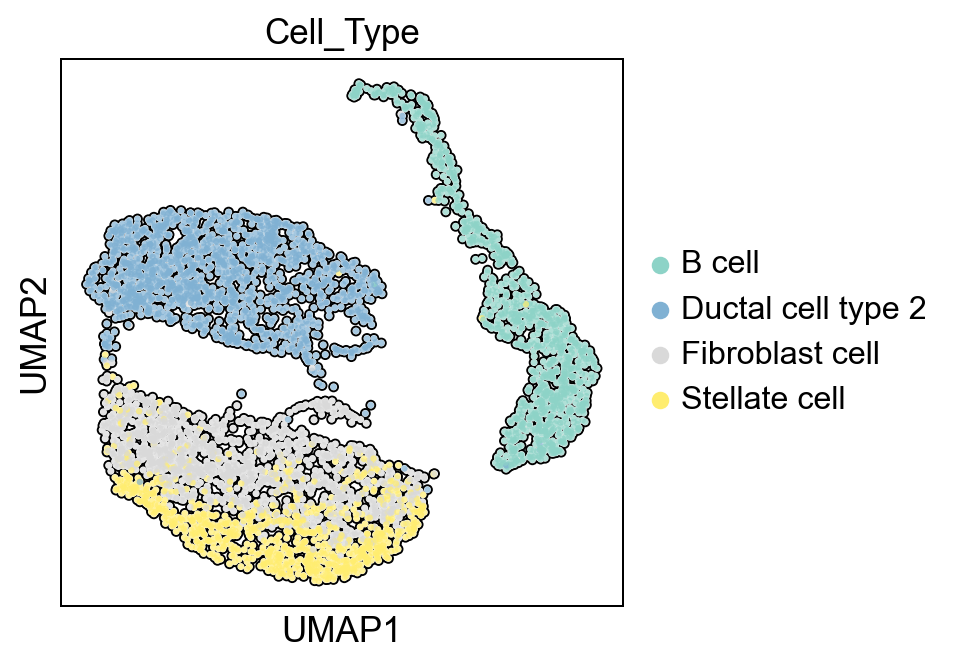

In [27]:
sc.set_figure_params(dpi=90)
pyviper.pl.umap(adata_PA,color="Cell_Type", palette="Set3", add_outline=True)

As an example, show the activity of selected markers for of ductal cells and fibroblasts in a dotplot.

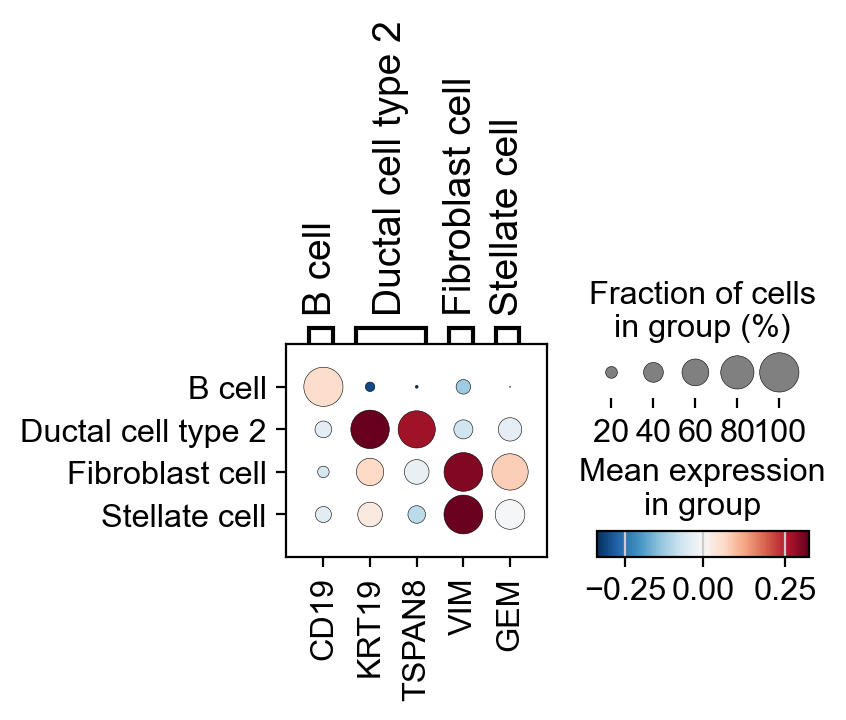

In [28]:
protein_markers_dict = {
    'B cell': 'CD19',
    'Ductal cell type 2': ['KRT19', 'TSPAN8'],
    'Fibroblast cell': 'VIM',
    'Stellate cell': 'GEM'
}
sc.set_figure_params(dpi=100)
pyviper.pl.dotplot(adata_PA, var_names=protein_markers_dict, layer="pes", groupby='Cell_Type', cmap="RdBu_r", vcenter=0)

Identify differentially active proteins on a cell type basis using the Wilcoxon Rank sum test and display a heatmap.

ranking genes
    finished (0:00:03)
    using 'X_pca' with n_pcs = 50
Storing dendrogram info using `.uns['dendrogram_Cell_Type']`


/Users/lucazanella7/mambaforge/envs/pyviper_development_test/lib/python3.13/site-packages/scanpy/tools/_rank_genes_groups.py:484: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/Users/lucazanella7/mambaforge/envs/pyviper_development_test/lib/python3.13/site-packages/scanpy/tools/_rank_genes_groups.py:484: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/Users/lucazanella7/mambaforge/envs/pyviper_development_test/lib/python3.13/site-packages/scanpy/tools/_rank_genes_groups.py:484: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/Users/lucazanella7/mambaforge/envs/pyviper_development_test/lib/python3.13/site-packages/scanpy/tools/_rank_genes_groups.py:484: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(


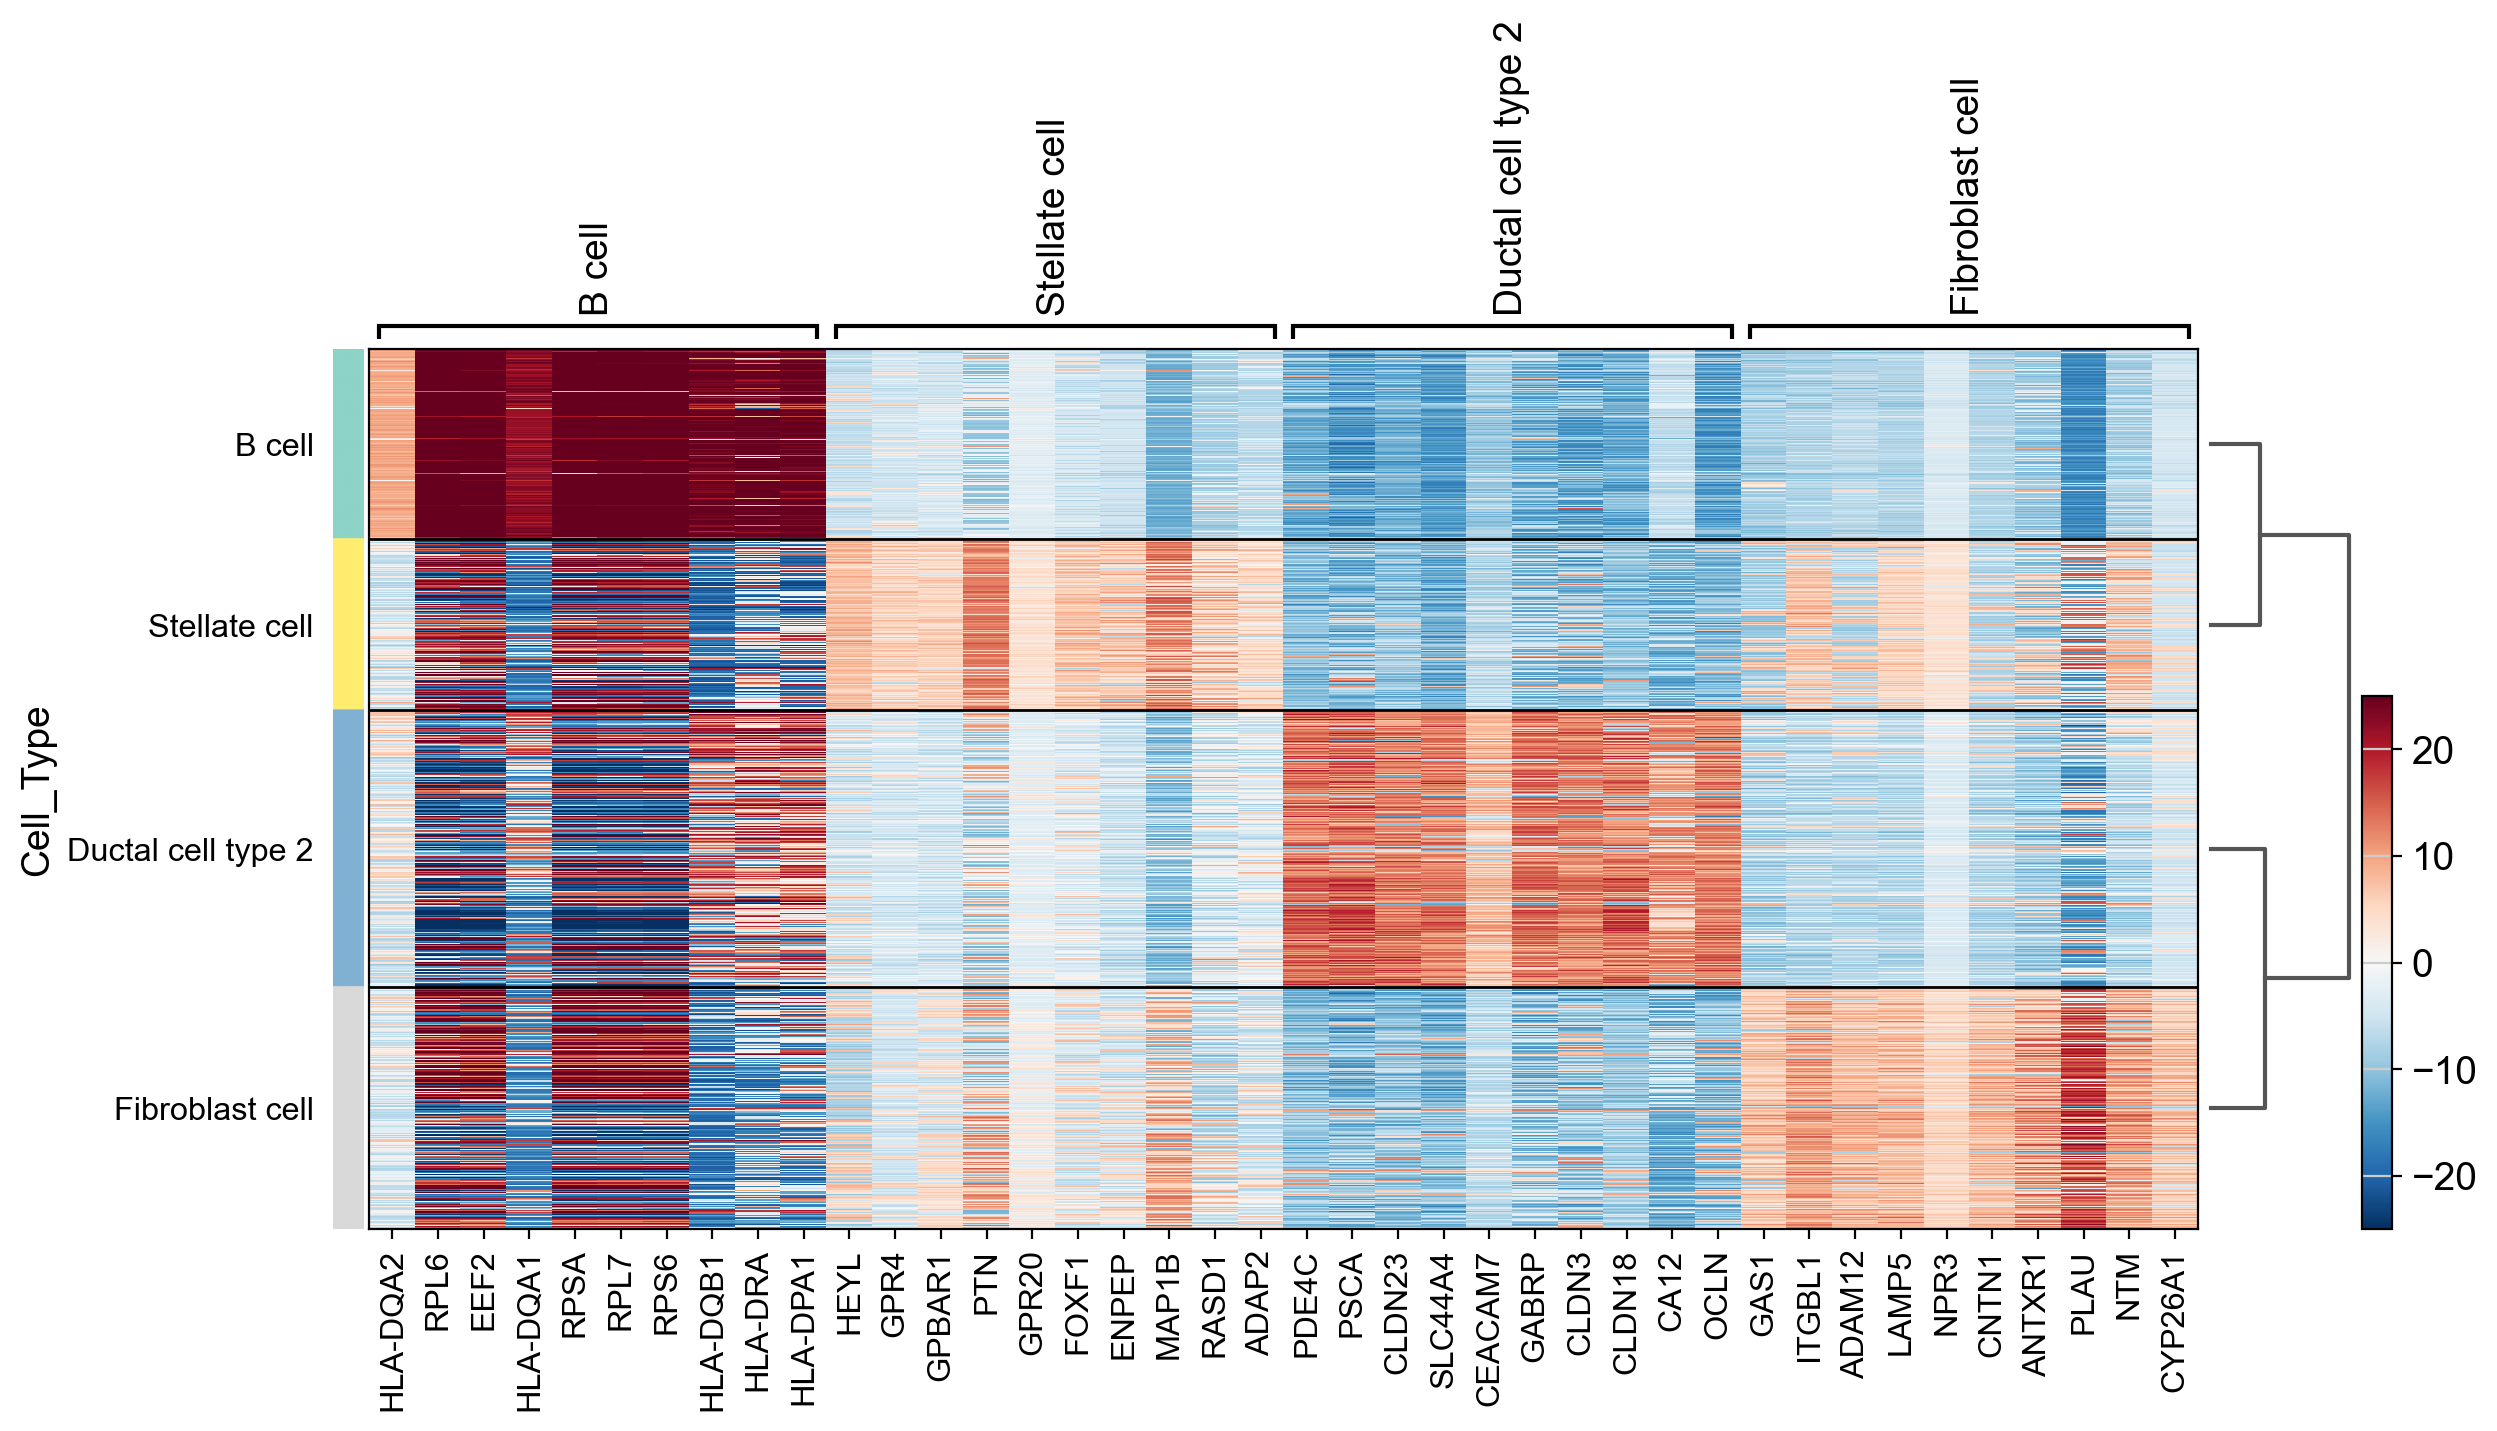

In [29]:
sc.settings.verbosity = 2  # reduce the verbosity
sc.tl.rank_genes_groups(adata=adata_PA, groupby='Cell_Type', use_raw=False, layer="pes", n_genes=20,  method='wilcoxon')
sc.pl.rank_genes_groups_heatmap(adata_PA, vmin=-25, vcenter=0, vmax=25, cmap='RdBu_r')


### Pathway enrichment analysis
<a id='5'></a>
Perform an enrichment analysis to identify biological functions associated to malignant cells by leveraging functional gene sets from the [MSigDB](https://www.gsea-msigdb.org/gsea/msigdb/index.jsp) collection. Through its `load` module,`pyviper` allows the user to choose between several MSigDB collections, including curated gene sets from online pathway databases ('c2'), ontology ('c5') and oncogenic signature ('c6') gene sets and immunologic signature gene sets ('c7').  

Load the 'hallmark gene sets' as an object of class `Interactome` and retain only the targets in common with the protein activity matrix.

In [30]:
hallmarks_MSigDB = pyviper.load.msigdb_regulon('h') # load hallmark of cancer MSigDB as an interactome
hallmarks_MSigDB.filter_targets(adata_PA.var_names)

Removed 3587 targets.


Perform the enrichment analysis using the `path_enr` function from `pyviper.tl`.

In [31]:
pathways_enrichment = pyviper.tl.path_enrich(adata_PA, interactome=hallmarks_MSigDB, enrichment="narnea", verbose="False")

Removed 0 targets.
Preparing the association scores
Computing regulons enrichment with NaRnEa
reordering genes
Calculating DES...
Calculating UES...
Calculating NES...
Calculating PES...


Focus on malignant ductal cells and compute the mean NES for each gene set.

In [32]:
pathways_enrichment = pathways_enrichment[pathways_enrichment.obs['Cell_Type'] == 'Ductal cell type 2'].copy()
Integrated_hallmarks_NES = pathways_enrichment.to_df().mean(axis=0)

Convert NES for each hallmark into p values and adjust for multiple hypothesis testing with the [Benjamini-Hochberg](https://www.jstor.org/stable/2346101) procedure.

In [33]:
Integrated_hallmarks_pvals = pyviper._pp._nes_to_pval_df(Integrated_hallmarks_NES, lower_tail=False, adjust=True)

Compute the -log10(P value) and display the top 5 enriched pathways.

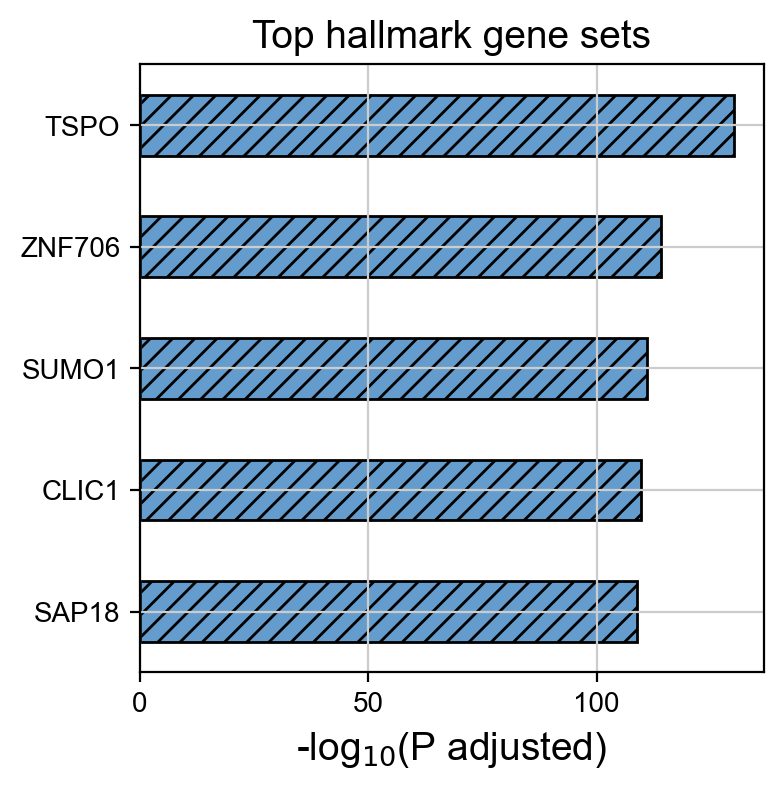

In [34]:
Integrated_hallmarks_mlog10 = -np.log10(Integrated_hallmarks_pvals) # convert to -log10(P adjust)

top_pathways = Integrated_hallmarks_mlog10.sort_values(ascending=True)[-5:] # sort by -log10(P value)

ax = top_pathways.plot(kind='barh', color='#649dcd', legend=False, fontsize=10, hatch='///', edgecolor='black')

plt.title("Top hallmark gene sets")
plt.xlabel("-log$_{10}$(P adjusted)")

plt.show()

### Key takeaways
<a id='6'></a>
This Tutorial describes how to generate a gene expression signature by exploiting the inter-operatibility between `pyviper` and `scanpy` and showed how to infer protein activity in single cells from multiple populations with the [metaVIPER](https://www.nature.com/articles/s41467-018-03843-3) approach, that leverages multiple lineage-specific regulatory networks. We conclude this Tutorial by presenting another key module used to perform pathway enrichment analysis.